In [1]:
import pandas as pd

USED_FILES = ['local_data/reddit_train_clean.csv']
    

train_datasets = []
for file in USED_FILES:
    train_file = pd.read_csv(file)
    train_file['unique_id'] = train_file.index.astype(str) + f'{file}'
    train_datasets.append(train_file[['unique_id', 'id', 'decoded_text']])
    
train = pd.concat(train_datasets).sample(frac=1.)
test = pd.read_csv('local_data/reddit_test.csv')

train.columns = ['unique_id', 'id', 'decoded_text']
test.columns = ['id', 'decoded_text', 'subreddit']

In [2]:
# Utilities
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from random import shuffle

TOKENIZER = AutoTokenizer.from_pretrained('roberta-large')

def embed(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      tokenized_texts.attention_mask.to(model.device),
                      )
    return embedding

def embed_transformer(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      attention_mask = tokenized_texts.attention_mask.to(model.device),
                      ).pooler_output
    return embedding

def evaluate(model, data, top_k=5, N=100, repetitions=1, embed_f=embed):
    with torch.no_grad():
        
        accs, topks = [], []
        for _ in tqdm(range(repetitions)):           
            authors = data.id.unique().tolist()
            shuffle(authors)
            random_authors = authors[:N]
            anchors, replicas = [], []
            for author in random_authors:
                anchor, replica = data.loc[author == data.id].decoded_text.sample(2).tolist()
                anchors.append(anchor)
                replicas.append(replica)
            
            embedding_anchors = F.normalize(embed_f(model, anchors))
            embedding_replicas = F.normalize(embed_f(model, replicas))

            preds = embedding_anchors @ embedding_replicas.T
            labels = torch.arange(0, len(preds)).numpy()

            preds_a = F.softmax(preds, dim=-1)
            preds_b = F.softmax(preds.T, dim=-1)

            a_acc = accuracy_score(labels, preds_a.argmax(-1).cpu().numpy())
            b_acc = accuracy_score(labels, preds_b.argmax(-1).cpu().numpy())
            a_topk = top_k_accuracy_score(y_true=labels, y_score=preds_a.cpu().numpy(), k=top_k)
            b_topk = top_k_accuracy_score(y_true=labels, y_score=preds_b.cpu().numpy(), k=top_k)

            accs.append((a_acc+b_acc)/2)
            topks.append((a_topk+b_topk)/2)

            del embedding_anchors
            del embedding_replicas

            torch.cuda.empty_cache()
            
        return np.mean(accs), np.mean(topks), np.std(accs), np.std(topks)

In [3]:
# Utilities
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from random import shuffle
import numpy as np

TOKENIZER = AutoTokenizer.from_pretrained('roberta-large')

def embed(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      tokenized_texts.attention_mask.to(model.device),
                      )
    return embedding

def embed_transformer(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      attention_mask = tokenized_texts.attention_mask.to(model.device),
                      ).pooler_output
    return embedding

def evaluate(model, data, top_k=5, N=100, repetitions=1, embed_f=embed):
    with torch.no_grad():
        
        accs, topks = [], []
        for _ in tqdm(range(repetitions)):           
            authors = data.id.unique().tolist()
            shuffle(authors)
            random_authors = authors[:N]
            anchors, replicas = [], []
            for author in random_authors:
                anchor, replica = data.loc[author == data.id].decoded_text.sample(2).tolist()
                anchors.append(anchor)
                replicas.append(replica)
            
            embedding_anchors = F.normalize(embed_f(model, anchors))
            embedding_replicas = F.normalize(embed_f(model, replicas))

            preds = embedding_anchors @ embedding_replicas.T
            labels = torch.arange(0, len(preds)).numpy()

            preds_a = F.softmax(preds, dim=-1)
            preds_b = F.softmax(preds.T, dim=-1)

            a_acc = accuracy_score(labels, preds_a.argmax(-1).cpu().numpy())
            b_acc = accuracy_score(labels, preds_b.argmax(-1).cpu().numpy())
            a_topk = top_k_accuracy_score(y_true=labels, y_score=preds_a.cpu().numpy(), k=top_k)
            b_topk = top_k_accuracy_score(y_true=labels, y_score=preds_b.cpu().numpy(), k=top_k)

            accs.append((a_acc+b_acc)/2)
            topks.append((a_topk+b_topk)/2)

            del embedding_anchors
            del embedding_replicas

            torch.cuda.empty_cache()
            
        return np.mean(accs), np.mean(topks), np.std(accs), np.std(topks)

In [4]:
from model_experimental import SupervisedContrastiveTransformerLast
from random import shuffle

REPEATS = 100
TOP_K = 5
DEVICE = 1

n_list = [10, 20, 50, 100, 250]
keys = ['all', 'blogs', 'books', 'mails']

data_dict = {}
# Pass on trained models
model_ckpt = "model/2022-09-14_08-38-43_reddit_supconloss.ckpt"
model = SupervisedContrastiveTransformerLast.load_from_checkpoint(checkpoint_path=model_ckpt).cuda(DEVICE)
        

for n in n_list:
    print(f'[log] Running {REPEATS} repetitions for N={n}\n')
    max_len = len(test.id.unique())
            
    if n == 'max':
        n = max_len

    if n <= max_len:
        acc, topk, acc_sd, topk_sd = evaluate(model, test, top_k=TOP_K, N=n, repetitions=REPEATS)
        print(f'[log] {n} Repeats: {100*acc:.2f}% {100*topk:.2f}%\n')
    
torch.cuda.empty_cache()

[log] Running 100 repetitions for N=10



  0%|          | 0/100 [00:00<?, ?it/s]

[log] 10 Repeats: 54.95% 91.05%

[log] Running 100 repetitions for N=20



  0%|          | 0/100 [00:00<?, ?it/s]

[log] 20 Repeats: 42.88% 77.10%

[log] Running 100 repetitions for N=50



  0%|          | 0/100 [00:00<?, ?it/s]

[log] 50 Repeats: 31.15% 59.24%

[log] Running 100 repetitions for N=100



  0%|          | 0/100 [00:00<?, ?it/s]

[log] 100 Repeats: 24.72% 47.35%

[log] Running 100 repetitions for N=250



  0%|          | 0/100 [00:00<?, ?it/s]

[log] 250 Repeats: 17.34% 34.21%



In [ ]:
# Utilities
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from random import shuffle

TOKENIZER = AutoTokenizer.from_pretrained('roberta-large')

def embed(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      tokenized_texts.attention_mask.to(model.device),
                      )
    return embedding

In [ ]:
candidate_subreddit = test.subreddit.unique()[:5]
candidate_ids = test[test.subreddit.isin(candidate_subreddit)].id.unique()[:250]

sub_test = test[test.id.isin(candidate_ids)]
sub_test

,id,decoded_text,subreddit
0,Wheelman,As an entrepreneur/freelancer (especially a su...,personalfinance
1,Perservere,Didn't they lose 6 games in a row? Just becaus...,leagueoflegends
2,XandarsMeteor,And yet that anonymity isn't always enough for...,atheism
3,lydocia,After seeing enough of these pre and post weig...,pics
4,mythin,"edit: this is long, I tried to explain in a po...",MensRights
...,...,...,...
106491,mean0dean0,Recent discussions about bias against women in...,MensRights
106520,retsudrats,The list below will be my thoughts on the game...,strife
106565,tomanonimos,I am about too choose a bike and the insurance...,motorcycles
106568,Rykku,"Hi-ho guys, new in town.\n\nSo, first day at t...",Fitness


In [ ]:
embeddings = []
for book_idx, book_df in tqdm(sub_test.groupby('id')):
    with torch.no_grad():
        batch = TOKENIZER(book_df.decoded_text.tolist()[:32], return_tensors='pt', padding='max_length', max_length=512, truncation=True)
        embedding = model(batch.input_ids.cuda(model.device), batch.attention_mask.cuda(model.device)).mean(0)
        embeddings.append(embedding.cpu())
    
embeddings = torch.stack(embeddings, 0)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
import re

grouped_df = sub_test.groupby('id')
authors = grouped_df.apply(lambda x: x.iloc[0]).id.tolist()
subreddit =  grouped_df.agg(lambda x: np.unique([s for s in x if s in candidate_subreddit]).tolist()).subreddit.tolist()

embedding_dataset = pd.DataFrame({'embedding': [embed for embed in embeddings.numpy()], 'subreddit': subreddit, 'author': authors})

In [ ]:
embedding_dataset

,embedding,subreddit,author
0,"[1.2558736, -0.32368144, 0.43212518, 0.3410892...",[leagueoflegends],0x61736466
1,"[-0.045158908, 0.55858636, 0.046210106, -0.219...",[atheism],7x5x3x2x2
2,"[0.7312315, -0.04843669, 0.6178136, -0.0377823...",[leagueoflegends],AWisdomTooth
3,"[1.2661055, 0.45056418, 0.50940067, 0.4390489,...",[leagueoflegends],Aftershock7
4,"[1.3325124, 0.10900685, 0.20655167, 0.32953557...",[leagueoflegends],Ajido
...,...,...,...
245,"[1.0554603, -0.174729, 0.3473021, 0.20636106, ...",[leagueoflegends],whoopashigitt
246,"[0.13759203, -0.31737453, 0.34518468, 0.444744...","[personalfinance, pics]",whosdamike
247,"[0.51971805, 0.51180345, 0.74021393, 0.1764975...",[pics],will4531
248,"[0.540111, 0.28537455, 0.585373, -0.048789095,...","[atheism, leagueoflegends]",xNIBx


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

def plot_df(main_df, topics):
    %matplotlib inline

    plt.figure(figsize=(7*2.5,4.5*2.5))
    
    sns.set_style("whitegrid")

    for i, topic in enumerate(topics):
        df = main_df[main_df.subreddit.apply(lambda x: topic in x)]
        ax = sns.scatterplot(x=jitter(df.umap_0, 0.5), # Horizontal axis
                y=jitter(df.umap_1, 0.5), # Vertical axis
                data=df, # Data source
                #hue='subreddit',
                s=50,
                palette="Spectral") # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    legend = plt.legend(title='Topic', labels=topics)
    legend.set_title('Book type')

    #frame = legend.get_frame() #sets up for color, edge, and transparency
    #frame.set_facecolor('#b4aeae') #color of legend
    #frame.set_edgecolor('black') #edge color of legend
    #frame.set_alpha(1) #deals with transparency
    
    return plt
    
def make_plot(data, topics, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=2)
    embeddings_train = data.embedding.tolist()
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                       'umap_1': reduced_embs[:,1],
                       'subreddit': data.subreddit.apply(lambda x: str(x)).tolist(),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df, topics)

neighbors = [3, 5, 10, 20]
min_dist = [.1, .25, .5, .75, .9, .99]

n_neighbors:10, min_dist:0.1


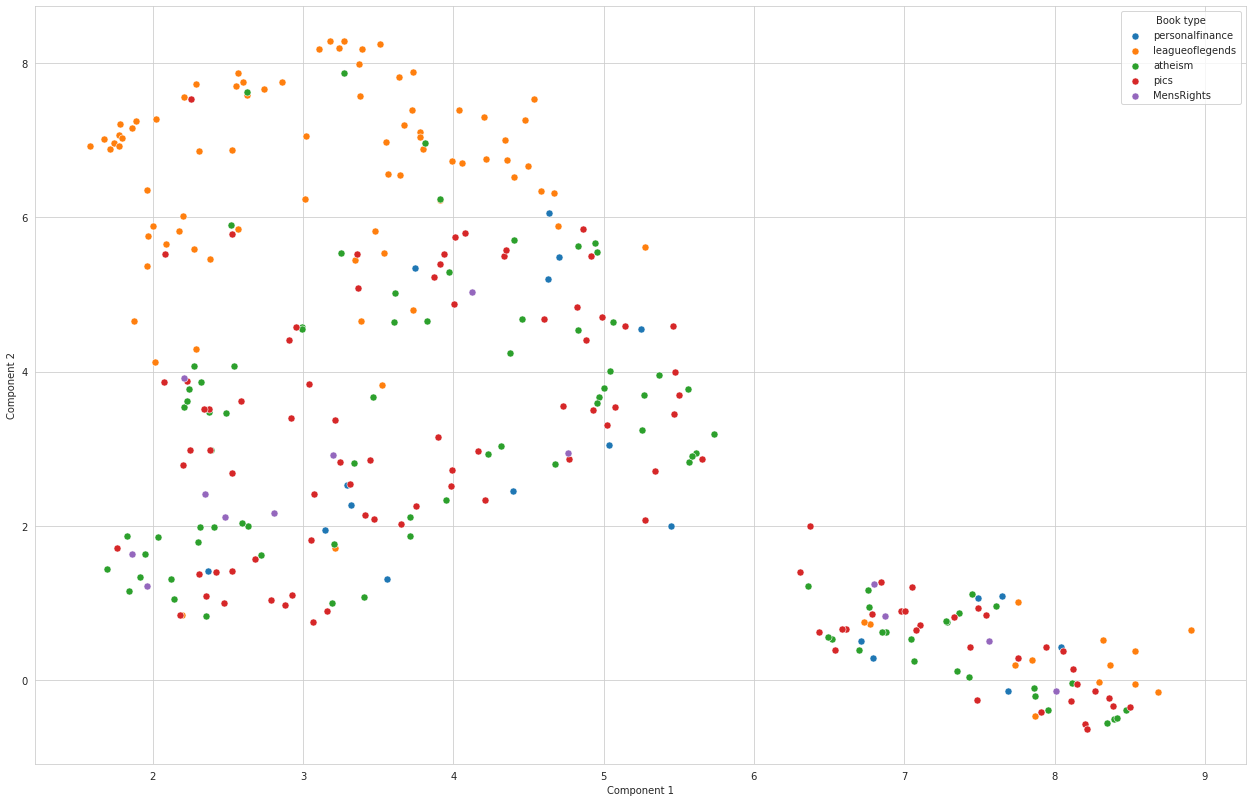

In [ ]:
plt = make_plot(embedding_dataset, candidate_subreddit, n_neighbors=10, min_dist=.1)
plt.tight_layout()
#plt.savefig("figures/books_umap.pdf", dpi=1000)

In [30]:
#Seleccion de características de acuerdo a la correlación

[['leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'LeagueofLegendsMeta',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends'],
 ['todayilearned',
  'atheism',
  'funny',
  'todayilearned',
  'AskReddit',
  'Bitcoin',
  'todayilearned',
  'AdviceAnimals',
  'trees',
  'electronic_cigarette',
  'electronic_cigarette',
  'facebookwins',
  'bicycling',
  'conspiracy',
  'fatpeoplestories',
  'funny',
  'bicycling',
  'AdviceAnimals',
  'bicycling',
  'firstworldproblems',
  'restorethefourth',
  'reddCoin',
  'reddCoin',
  'worldnews',
  'AskReddit',
  'Libertarian',
  'worldnews',
  'BitcoinMining',
  'videos',
  'DIY',
  'Anxiety',
  'funny',
  'RealGirls',
  'VapePorn',
  'reddCoin'],
 ['leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'AskReddit',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflegends',
  'leagueoflege